# Disaster Tweets with NLP and Pytorch

The Natural Language Processing with Disaster Tweets competition on Kaggle challenge to build a machine learning model that can classify whether a given tweet is about a real disaster or not.

## Problem Description:

We are provided with a dataset of tweets, each labeled as either referring to a real disaster (1) or not (0).

The task is to predict the label for new, unseen tweets based on their text content.

This is a binary text classification problem, commonly solved using natural language processing (NLP) techniques.

The main goal is to learn and practice NLP model development and evaluation in a real-world context.

## Goal:
Develop a model that accurately distinguishes disaster-related tweets from non-disaster tweets, helping automate disaster response and information filtering on social media.

[Link to kaggle competition](https://www.kaggle.com/competitions/nlp-getting-started/overview)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import re
import spacy

import torch
import torch.nn as nn
import torch.optim as optim

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torchinfo import summary

In [2]:
# Setup some constants
nlp = spacy.load("en_core_web_sm")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE= 64
EMBED_DIM = 100
HIDDEN_DIM = 128
DROPOUT = 0.3
LR = 0.0001
EPOCHS = 15

In [4]:

def clean_tweet(text, nlp):
    # Remove URLs, mentions, hashtags
    text = re.sub(r"http\S+|@\w+|#\w+", "", text)
    doc = nlp(text.lower())
    tokens = [
        token.lemma_ for token in doc
        if token.is_alpha and not token.is_stop
    ]
    return tokens

def build_vocab(texts, nlp, min_freq=2):
    counts = Counter()
    for text in texts:
        tokens = clean_tweet(text, nlp)
        counts.update(tokens)
    vocab = {'<pad>': 0, '<unk>': 1}
    idx = 2
    for word, count in counts.items():
        if count >= min_freq and word not in vocab:
            vocab[word] = idx
            idx += 1
    return vocab

## EDA

### Explore and inspect data

In [5]:
# Load data
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
train_df, val_df = train_test_split(train_df, test_size=0.1)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6851 entries, 6234 to 2386
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        6851 non-null   int64 
 1   keyword   6801 non-null   object
 2   location  4590 non-null   object
 3   text      6851 non-null   object
 4   target    6851 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 321.1+ KB


In [6]:
train_df.sample(5)

,id,keyword,location,text,target
864,1249,blood,Bug Forest,Guys. I have an Imouto Who Isn't Actually Rela...,0
1135,1636,bombing,"Sydney, Australia",Today marks the 70th anniversary of the bombin...,1
2674,3836,detonate,"Morioh, Japan",@spinningbot Are you another Stand-user? If yo...,0
7487,10709,wreck,NaN,My emotions are a train wreck. My body is a tr...,0
2562,3675,destroy,NaN,Get a 50 Eur free bet at BWIN to use on all sp...,0


In [7]:
# print the number of records per label type
# 0 = false disaster
# 1 = true disaster
train_df['target'].value_counts()

target
0    3923
1    2928
Name: count, dtype: int64

In [8]:
# build vocabulary
vocab = build_vocab(train_df['text'], nlp)

In [9]:
max_idx = max(vocab.values())
print("Max vocab index:", max_idx)
print("Vocab size:", len(vocab))

Max vocab index: 4376
Vocab size: 4377


## Create Dataset object for data loading


In [10]:
class DisasterTweetDataset(Dataset):
    def __init__(self, df, vocab, max_len=50):
        self.df = df
        self.vocab = vocab
        self.max_len = max_len

        # Build inverse vocab (index to token)
        self.inv_vocab = {idx: token for token, idx in vocab.items()}
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        text = self.df.iloc[idx]['text']
        target = self.df.iloc[idx]['target']
        
        # Tokenize and numericalize
        tokens = [token.text.lower() for token in nlp.tokenizer(text)][:self.max_len]
        numericalized = [self.vocab.get(token, self.vocab['<unk>']) for token in tokens]
        
        return (
            torch.tensor(numericalized, dtype=torch.long),
            torch.tensor(target, dtype=torch.float)
        )
    
    def get_random_indices(self, n):
        return random.sample(range(self.__len__()), n)
    
    def print_sample(self, n):
        rand_indices = self.get_random_indices(n)
        for idx, i in enumerate(rand_indices):
            numericalized, target = self.__getitem__(idx)
            print(f'Tensor numerical representation: {numericalized}, target: {target}')

            # Convert tensor to list
            if hasattr(numericalized, 'tolist'):
                numericalized = numericalized.tolist()
                target = target.tolist()
            
            # Convert indices back to tokens
            tokens = [self.inv_vocab.get(i, '<unk>') for i in numericalized]
            # Join tokens into a string
            string = ' '.join(tokens)

            print(f'Text representation: {string}, target: {target}')

    @staticmethod
    def collate_fn(batch):
        # Sort batch by sequence length
        batch.sort(key=lambda x: len(x[0]), reverse=True)
        sequences, targets = zip(*batch)
        lengths = torch.tensor([len(seq) for seq in sequences])
        
        # Pad sequences
        padded_seqs = pad_sequence(sequences, batch_first=True)
        return padded_seqs, torch.stack(targets), lengths

## Load data

In [11]:
# Create datasets and dataloaders
train_ds = DisasterTweetDataset(train_df, vocab)
val_ds = DisasterTweetDataset(val_df, vocab)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, 
                         shuffle=True, collate_fn=DisasterTweetDataset.collate_fn)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE,
                       collate_fn=DisasterTweetDataset.collate_fn)

In [12]:
train_ds.print_sample(2)

Tensor numerical representation: tensor([ 2,  3,  4,  5,  6,  1,  1,  8,  9, 10,  1,  1,  1,  1,  1,  1,  1]), target: 1.0
Text representation: sassy city girl country hunk <unk> <unk> smoky mountain snowstorm <unk> <unk> <unk> <unk> <unk> <unk> <unk>, target: 1.0
Tensor numerical representation: tensor([ 1, 11,  1,  1,  1,  1, 13,  1,  1,  1,  1,  1,  1,  1, 17]), target: 0.0
Text representation: <unk> ty <unk> <unk> <unk> <unk> motor <unk> <unk> <unk> <unk> <unk> <unk> <unk> ok, target: 0.0


## Build Model


|Feature           |DisasterGRU |DisasterGRU2   |DisasterGRU3|
|------------------|------------|---------------|------------|
|Padding Handling  |None        |padding_idx    |padding_idx
|Normalization     |None        |               |
|Dropout Placement |After embedding |Post-concat|Post-concat
|Sequence Processing| Basic packing |CPU length conversion|CPU length conversion
|Stability Features|None|Hidden state norm|Dual normalization

In [13]:
class DisasterGRU(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(embed_dim, hidden_dim, 
                          bidirectional=True, 
                          dropout=dropout,
                          batch_first=True)
        self.fc = nn.Linear(hidden_dim*2, 1)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        embedded = self.dropout(self.embedding(text))
        
        # Pack padded sequence
        packed_embedded = pack_padded_sequence(
            embedded, text_lengths, 
            batch_first=True, enforce_sorted=False
        )
        
        packed_output, hidden = self.gru(packed_embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return self.fc(hidden).squeeze(1)


class DisasterGRU2(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, dropout, pad_idx=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.gru = nn.GRU(
            embed_dim, hidden_dim, 
            bidirectional=True, 
            dropout=dropout if dropout > 0 else 0, 
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim * 2, 1)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)  # Optional: for stability

    def forward(self, text, text_lengths):
        # Embedding + dropout
        embedded = self.dropout(self.embedding(text))

        # Pack padded sequence for efficient GRU processing
        packed_embedded = pack_padded_sequence(
            embedded, text_lengths.cpu(), 
            batch_first=True, enforce_sorted=False
        )
        packed_output, hidden = self.gru(packed_embedded)
        
        # Concatenate the final forward and backward hidden states
        hidden_cat = torch.cat((hidden[-2], hidden[-1]), dim=1)
        hidden_cat = self.dropout(hidden_cat)
        hidden_cat = self.layer_norm(hidden_cat)  # Optional: improves stability

        return self.fc(hidden_cat).squeeze(1)


class DisasterGRU3(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, dropout, pad_idx=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.gru = nn.GRU(
            embed_dim, hidden_dim, 
            bidirectional=True, 
            dropout=dropout if dropout > 0 else 0, 
            batch_first=True
        )
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)  # LayerNorm for stability
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)  # BatchNorm for feature normalization
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, text, text_lengths):
        embedded = self.dropout(self.embedding(text))
        packed_embedded = pack_padded_sequence(
            embedded, text_lengths.cpu(), 
            batch_first=True, enforce_sorted=False
        )
        packed_output, hidden = self.gru(packed_embedded)
        # Concatenate the final forward and backward hidden states
        hidden_cat = torch.cat((hidden[-2], hidden[-1]), dim=1)
        hidden_cat = self.dropout(hidden_cat)
        hidden_cat = self.layer_norm(hidden_cat)
        # BatchNorm expects (batch_size, num_features)
        hidden_cat = self.batch_norm(hidden_cat)
        return self.fc(hidden_cat).squeeze(1)

In [14]:
model = DisasterGRU(
    vocab_size=len(vocab),
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    dropout=DROPOUT
).to(device)

model2 = DisasterGRU2(
    vocab_size=len(vocab),
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    dropout=DROPOUT
).to(device)

model3 = DisasterGRU3(
    vocab_size=len(vocab),
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    dropout=DROPOUT
).to(device)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


In [15]:
SEQ_LEN = 40
text = torch.randint(0, len(vocab), (BATCH_SIZE, SEQ_LEN), dtype=torch.long)
text_lengths = torch.full((BATCH_SIZE,), SEQ_LEN, dtype=torch.long)

summary(model, input_data=(text, text_lengths))


Layer (type:depth-idx)                   Output Shape              Param #
DisasterGRU                              [64]                      --
├─Embedding: 1-1                         [64, 40, 100]             437,700
├─Dropout: 1-2                           [64, 40, 100]             --
├─GRU: 1-3                               [2560, 256]               176,640
├─Dropout: 1-4                           [64, 256]                 --
├─Linear: 1-5                            [64, 1]                   257
Total params: 614,597
Trainable params: 614,597
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 115.79
Input size (MB): 0.02
Forward/backward pass size (MB): 7.29
Params size (MB): 2.46
Estimated Total Size (MB): 9.77

In [16]:
summary(model2, input_data=(text, text_lengths))

Layer (type:depth-idx)                   Output Shape              Param #
DisasterGRU2                             [64]                      --
├─Embedding: 1-1                         [64, 40, 100]             437,700
├─Dropout: 1-2                           [64, 40, 100]             --
├─GRU: 1-3                               [2560, 256]               176,640
├─Dropout: 1-4                           [64, 256]                 --
├─LayerNorm: 1-5                         [64, 256]                 512
├─Linear: 1-6                            [64, 1]                   257
Total params: 615,109
Trainable params: 615,109
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 115.79
Input size (MB): 0.02
Forward/backward pass size (MB): 7.42
Params size (MB): 2.46
Estimated Total Size (MB): 9.90

In [17]:
summary(model3, input_data=(text, text_lengths))

Layer (type:depth-idx)                   Output Shape              Param #
DisasterGRU3                             [64]                      --
├─Embedding: 1-1                         [64, 40, 100]             437,700
├─Dropout: 1-2                           [64, 40, 100]             --
├─GRU: 1-3                               [2560, 256]               176,640
├─Dropout: 1-4                           [64, 256]                 --
├─LayerNorm: 1-5                         [64, 256]                 512
├─BatchNorm1d: 1-6                       [64, 256]                 512
├─Linear: 1-7                            [64, 1]                   257
Total params: 615,621
Trainable params: 615,621
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 115.79
Input size (MB): 0.02
Forward/backward pass size (MB): 7.55
Params size (MB): 2.46
Estimated Total Size (MB): 10.04

In [18]:
# Load pre-trained embeddings (GloVe)
def load_glove_embeddings(vocab):
    embeddings = np.random.normal(scale=0.6, size=(len(vocab), EMBED_DIM))
    with open("/kaggle/input/glove6b100dtxt/glove.6B.100d.txt", 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            if word in vocab:
                embeddings[vocab[word]] = np.array(values[1:], dtype=np.float32)
    return torch.tensor(embeddings)

model.embedding.weight.data.copy_(load_glove_embeddings(vocab))
model.embedding.weight.requires_grad = False  # Freeze embeddings

## Model Validation

In [19]:
def train_model(model):
    # Initialize lists to store metrics
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    # Training setup
    optimizer = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.BCEWithLogitsLoss()
    
    # Training loop
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
    
        for texts, targets, lengths in train_loader:
            texts, targets = texts.to(device), targets.to(device)
            optimizer.zero_grad()
            predictions = model(texts, lengths)
            loss = criterion(predictions, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
    
        # Validation
        model.eval()

        val_loss = 0
        correct = 0
        all_targets = []
        all_probs = []
        
        with torch.no_grad():
            for texts, targets, lengths in val_loader:
                texts, targets = texts.to(device), targets.to(device)
                predictions = model(texts, lengths)
                val_loss += criterion(predictions, targets).item()
                correct += ((torch.sigmoid(predictions) > 0.5).float() == targets).sum().item()
                # Collect for ROC
                all_targets.append(targets.cpu())
                all_probs.append(torch.sigmoid(predictions).cpu())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_acc = correct / len(val_ds)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{EPOCHS} -- Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f} --Val Acc: {val_acc:.4f}")

    # After training, flatten and concatenate targets and probabilities
    y_true = torch.cat(all_targets).numpy()
    y_score = torch.cat(all_probs).numpy()

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    # Plotting metrics after training
    plt.figure(figsize=(20, 4))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    # ROC Curve
    plt.subplot(1, 3, 3)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Validation ROC Curve')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()




Epoch 1/15 -- Train Loss: 0.4801
Val Loss: 0.4911 --Val Acc: 0.7598
Epoch 2/15 -- Train Loss: 0.4695
Val Loss: 0.4775 --Val Acc: 0.7835
Epoch 3/15 -- Train Loss: 0.4704
Val Loss: 0.4786 --Val Acc: 0.7795
Epoch 4/15 -- Train Loss: 0.4671
Val Loss: 0.4782 --Val Acc: 0.7795
Epoch 5/15 -- Train Loss: 0.4720
Val Loss: 0.4769 --Val Acc: 0.7756
Epoch 6/15 -- Train Loss: 0.4770
Val Loss: 0.4757 --Val Acc: 0.7782
Epoch 7/15 -- Train Loss: 0.4620
Val Loss: 0.4781 --Val Acc: 0.7782
Epoch 8/15 -- Train Loss: 0.4699
Val Loss: 0.4880 --Val Acc: 0.7782
Epoch 9/15 -- Train Loss: 0.4663
Val Loss: 0.4806 --Val Acc: 0.7677
Epoch 10/15 -- Train Loss: 0.4710
Val Loss: 0.4751 --Val Acc: 0.7822
Epoch 11/15 -- Train Loss: 0.4621
Val Loss: 0.4752 --Val Acc: 0.7782
Epoch 12/15 -- Train Loss: 0.4582
Val Loss: 0.4757 --Val Acc: 0.7677
Epoch 13/15 -- Train Loss: 0.4596
Val Loss: 0.4722 --Val Acc: 0.7769
Epoch 14/15 -- Train Loss: 0.4592
Val Loss: 0.4754 --Val Acc: 0.7717
Epoch 15/15 -- Train Loss: 0.4593
Val Loss:

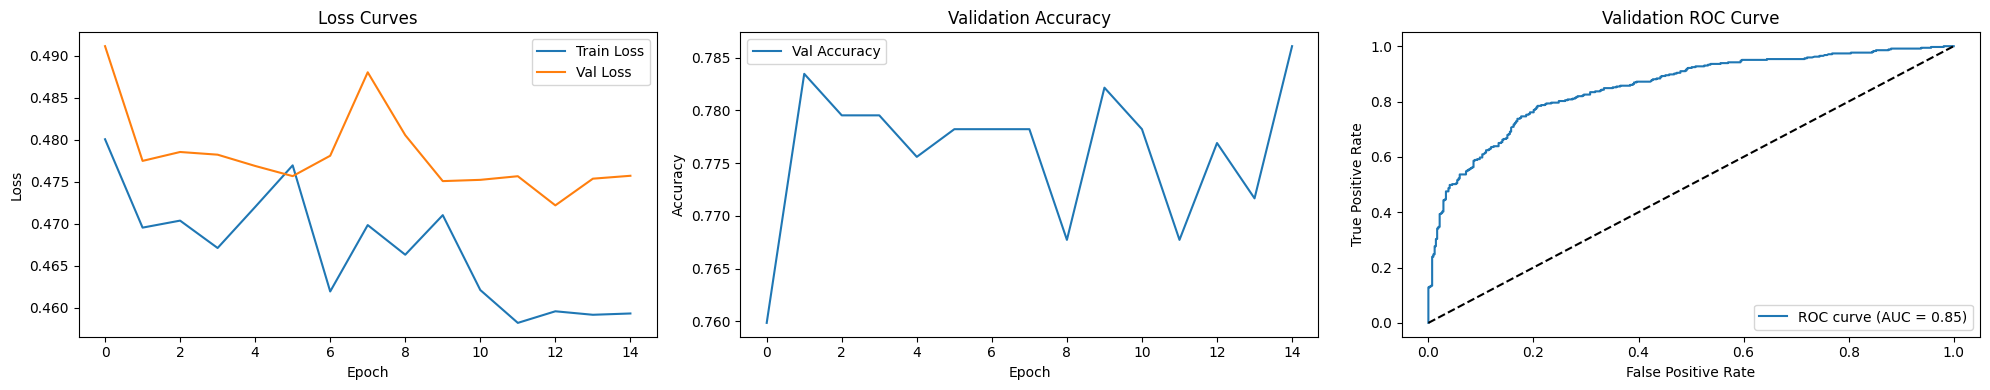

In [21]:
train_model(model)

Epoch 1/15 -- Train Loss: 0.6953
Val Loss: 0.6853 --Val Acc: 0.5643
Epoch 2/15 -- Train Loss: 0.6802
Val Loss: 0.6840 --Val Acc: 0.5735
Epoch 3/15 -- Train Loss: 0.6721
Val Loss: 0.6858 --Val Acc: 0.5748
Epoch 4/15 -- Train Loss: 0.6638
Val Loss: 0.6663 --Val Acc: 0.5827
Epoch 5/15 -- Train Loss: 0.6568
Val Loss: 0.6620 --Val Acc: 0.5971
Epoch 6/15 -- Train Loss: 0.6507
Val Loss: 0.6496 --Val Acc: 0.5984
Epoch 7/15 -- Train Loss: 0.6367
Val Loss: 0.6431 --Val Acc: 0.6207
Epoch 8/15 -- Train Loss: 0.6254
Val Loss: 0.6240 --Val Acc: 0.6430
Epoch 9/15 -- Train Loss: 0.6041
Val Loss: 0.6210 --Val Acc: 0.6378
Epoch 10/15 -- Train Loss: 0.5907
Val Loss: 0.6046 --Val Acc: 0.6772
Epoch 11/15 -- Train Loss: 0.5686
Val Loss: 0.6417 --Val Acc: 0.6640
Epoch 12/15 -- Train Loss: 0.5649
Val Loss: 0.6145 --Val Acc: 0.6745
Epoch 13/15 -- Train Loss: 0.5510
Val Loss: 0.6236 --Val Acc: 0.6785
Epoch 14/15 -- Train Loss: 0.5370
Val Loss: 0.6070 --Val Acc: 0.6890
Epoch 15/15 -- Train Loss: 0.5290
Val Loss:

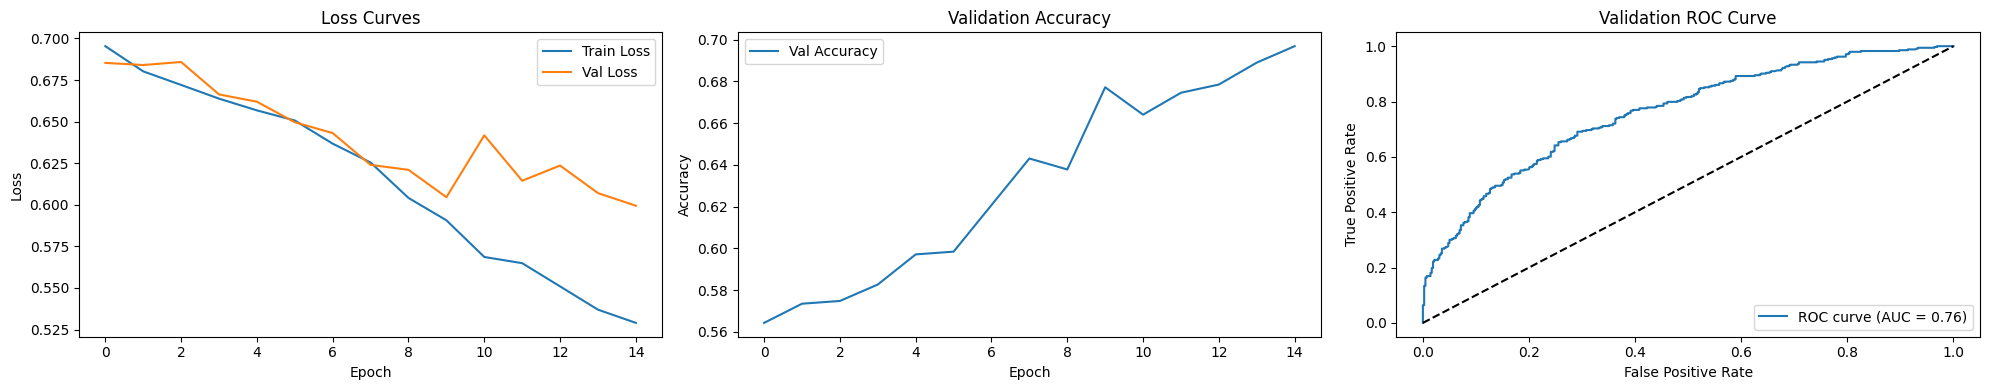

In [22]:
train_model(model2)

Epoch 1/15 -- Train Loss: 0.7097
Val Loss: 0.6863 --Val Acc: 0.5486
Epoch 2/15 -- Train Loss: 0.6861
Val Loss: 0.6744 --Val Acc: 0.5761
Epoch 3/15 -- Train Loss: 0.6681
Val Loss: 0.6657 --Val Acc: 0.5945
Epoch 4/15 -- Train Loss: 0.6580
Val Loss: 0.6606 --Val Acc: 0.6063
Epoch 5/15 -- Train Loss: 0.6441
Val Loss: 0.6478 --Val Acc: 0.6194
Epoch 6/15 -- Train Loss: 0.6353
Val Loss: 0.6364 --Val Acc: 0.6352
Epoch 7/15 -- Train Loss: 0.6202
Val Loss: 0.6238 --Val Acc: 0.6601
Epoch 8/15 -- Train Loss: 0.6045
Val Loss: 0.6199 --Val Acc: 0.6745
Epoch 9/15 -- Train Loss: 0.5896
Val Loss: 0.6101 --Val Acc: 0.6864
Epoch 10/15 -- Train Loss: 0.5804
Val Loss: 0.6018 --Val Acc: 0.6903
Epoch 11/15 -- Train Loss: 0.5659
Val Loss: 0.5991 --Val Acc: 0.6680
Epoch 12/15 -- Train Loss: 0.5567
Val Loss: 0.5860 --Val Acc: 0.7152
Epoch 13/15 -- Train Loss: 0.5457
Val Loss: 0.5943 --Val Acc: 0.6929
Epoch 14/15 -- Train Loss: 0.5414
Val Loss: 0.5812 --Val Acc: 0.6969
Epoch 15/15 -- Train Loss: 0.5238
Val Loss:

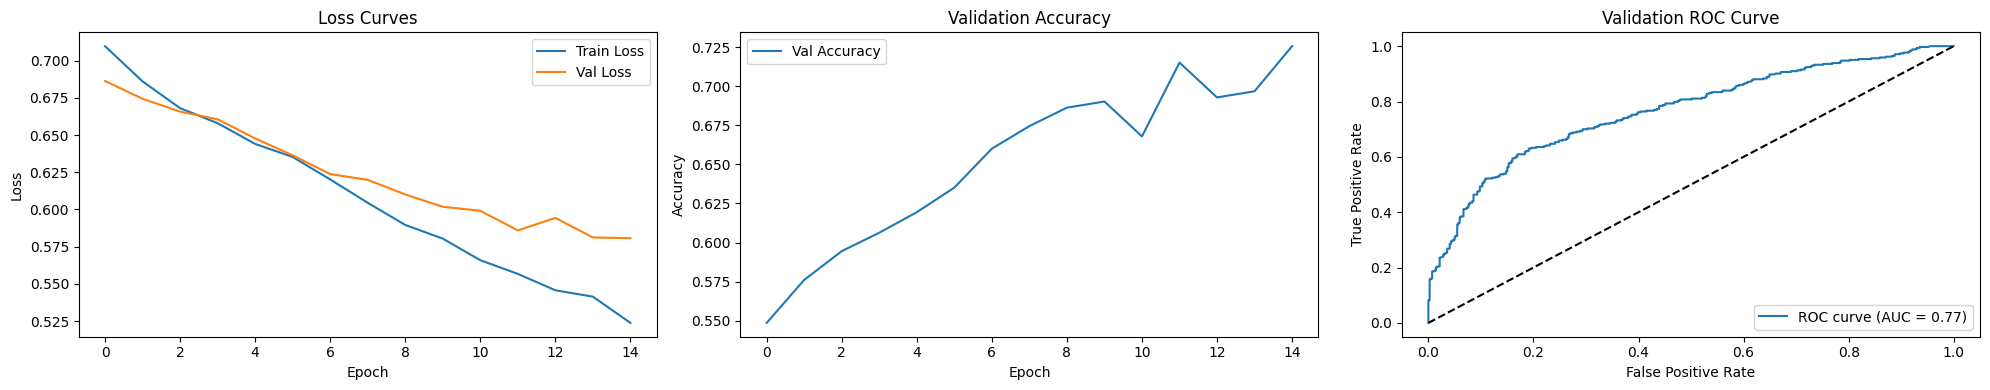

In [23]:
train_model(model3)

### Summary

#### Model:DisasterGRU
- Performance: Achieves the lowest validation loss (0.4705) and highest validation accuracy (0.7822).
- Learning Curve: Rapid improvement in early epochs; validation accuracy plateaus and remains stable after epoch 6.
- Overfitting: Minimal—training and validation losses decrease together, and validation accuracy does not degrade in later epochs.
- This model generalizes well and is the most robust among the three.

### Model: DisasterGRU2
- Performance: Higher final validation loss (0.5551) and lower best validation accuracy (0.7362) compared to model.
- Learning Curve: Improvement is slower and more gradual; validation accuracy continues to rise but at a diminished rate.
- Overfitting: Some evidence—validation loss fluctuates and does not consistently decrease in later epochs, while training loss continues to drop.
- The addition of LayerNorm and padding index may help stability but does not outperform the simpler model in this run.

### Model: DisasterGRU3
- Performance: Similar to model2, with final validation loss (0.5598) and best validation accuracy (0.7297).
- Learning Curve: Gradual improvement; some fluctuation in validation loss and accuracy in later epochs.
- Overfitting: Some signs—training loss drops more than validation loss, and validation accuracy plateaus.
- Adding both LayerNorm and BatchNorm does not yield significant gains and may introduce complexity without clear benefit for this dataset.

## Model selection:

- Model 1 is the best choice for this task and dataset, as it offers the strongest and most stable validation performance with the least complexity.
- Normalization layers (as in Model 2 and 3) did not improve results and may even hinder performance in this context, possibly due to the nature of text data and variable sequence lengths.
- Simplicity can be powerful: In many NLP tasks, a well-regularized, straightforward model can outperform more complex architectures, especially when the dataset is not extremely large or diverse.
- Generalization is key: Model 1’s ability to maintain low validation loss and high accuracy across epochs shows it generalizes well, which is crucial for real-world deployment.

## Recommendation:
- Continue with Model 1 for this problem. 
- If further improvement is needed, focus on data augmentation, better preprocessing, or tuning embedding and hidden dimensions, rather than adding architectural complexity. 
- Always validate changes with cross-validation or on a held-out test set to ensure genuine improvement.

In [24]:
# Generate submission
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
test_df['target'] = 0
test_ds = DisasterTweetDataset(test_df, vocab)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, collate_fn=DisasterTweetDataset.collate_fn)

model.eval()
predictions = []
with torch.no_grad():
    for texts, _, lengths in test_loader:
        texts = texts.to(device)
        batch_preds = torch.sigmoid(model(texts, lengths))
        predictions.extend(batch_preds.cpu().numpy())


In [ ]:
submission = pd.DataFrame({
    "id": test_df["id"],
    "target": (np.array(predictions) > 0.5).astype(int)
})
submission.to_csv("submission.csv", index=False)